In [1]:
import feather
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

In [2]:
import os
from settings import *

In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [4]:
d = pd.read_csv(os.path.join(DATA, 'raw', 'train_sample.csv'), 
                dtype=dtypes, 
                usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
# d.click_time = pd.to_datetime(d.click_time)

In [148]:
d = pd.read_csv(os.path.join(DATA, 'raw', 'train.csv'), 
                nrows= 1000000,
                dtype=dtypes, 
                usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

In [149]:
d.head(5)

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [5]:
def preprocess_date(d):
    # extract day of week, time of day (number of seconds since 00:00:00)
    
    d.click_time = pd.to_datetime(d.click_time)
    
    d['hour'] = d.click_time.dt.hour
    d['minute'] = d.click_time.dt.minute
    d['quarter'] = ((d.click_time.dt.minute + 1) % 4 ) + (d.click_time.dt.hour + 1) * 4
    # d['second'] = d.click_time.dt.second

    d['time'] = d.click_time.dt.hour * 3600 + d.click_time.dt.minute * 60 + d.click_time.dt.second

#     d['date'] = d.click_time \
#         .dt.date \
#         .apply(lambda x: x.strftime('%Y%m%d')) \
#         .astype(int)
    d['date'] = d.click_time.dt.year*100 + d.click_time.dt.month
        
#     d['day_of_week'] = d.click_time.dt.dayofweek
#     d['week'] = d.click_time.dt.weekofyear
    
    del d['click_time']
    del d['hour'], d['minute']
    
    return d

In [6]:
def create_grouped_var(d, group_vars, variable):
    
    select_vars = group_vars #+ [variable]
    name = 'n_' + '_'.join(group_vars)# + '_' + variable
    
    return d.merge( \
                    d[select_vars] \
                        .groupby(by=group_vars) \
                        .size().reset_index() \
                        .rename(index=str, columns={0: name}),
        on=group_vars, \
        how='left')

In [7]:
def create_grouped_vars(d):
    
#     d = create_grouped_var(d, ['ip', 'day_of_week', 'quarter'], 'channel')
    d = create_grouped_var(d, ['ip', 'quarter', 'app'], 'app')
    d = create_grouped_var(d, ['ip', 'quarter', 'device'], 'device')
    d = create_grouped_var(d, ['ip', 'quarter', 'os'], 'os')
    d = create_grouped_var(d, ['ip', 'quarter', 'channel'], 'channel')
    
    d = create_grouped_var(d, ['ip', 'date', 'app'], 'app')
    d = create_grouped_var(d, ['ip', 'date', 'device'], 'device')
    d = create_grouped_var(d, ['ip', 'date', 'os'], 'os')
    d = create_grouped_var(d, ['ip', 'date', 'channel'], 'channel')
    
    return d

In [8]:
def square_features(d, feature_list):
    for f in feature_list:
        d[f + '_sq'] = d[f] ** 2    
    return d

In [9]:
def lag_variable(d, group_vars, var_name):
    return d.merge(d[group_vars + [var_name, 'date1']].drop_duplicates(),
                   left_on = group_vars + ['date'],
                   right_on = group_vars + ['date1'],
                   suffixes= ['', '_1'],
                   how='left') \
            .drop('date1_1', axis=1)

In [10]:
def lag_variables(d, t=1):
    
    d['date1'] = d.date + t
    
    d = lag_variable(d, ['ip', 'quarter', 'app'], 'n_ip_date_app')
    d = lag_variable(d, ['ip', 'quarter', 'device'], 'n_ip_date_device')
    d = lag_variable(d, ['ip', 'quarter', 'os'], 'n_ip_date_os')
    d = lag_variable(d, ['ip', 'quarter', 'channel'], 'n_ip_date_channel')
    
    return d.drop('date1', axis=1)

In [11]:
# lag_variable(d, ['ip', 'quarter', 'app'], 'n_ip_quarter_app').shape

Skip

In [117]:
d = preprocess_date(d)

In [123]:
d = create_grouped_vars(d)

In [40]:
d = square_features(d, ['n_ip_quarter_app_app', 'n_ip_quarter_device_device', 'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel'])

In [83]:
d=d0.copy()

#### train data

In [12]:
d = pd.read_csv(os.path.join(DATA, 'raw', 'train.csv'), 
                dtype=dtypes, 
                usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

In [43]:
# d = pd.read_csv(os.path.join(DATA, 'raw', 'train.csv'))

In [13]:
d = preprocess_date(d)

In [ ]:
d = create_grouped_vars(d)

In [ ]:
d = lag_variables(d, t=1)

In [ ]:
d = square_features(d, ['n_ip_quarter_app_app', 'n_ip_quarter_device_device', 'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel'])

In [ ]:
feather.write_dataframe(d, os.path.join(DATA, 'processed', 'train_processed.feather'))

#### test data

In [ ]:
d = pd.read_csv(os.path.join(DATA, 'raw', 'test.csv'), 
                dtype=dtypes, 
                usecols=['click_id', 'ip','app','device','os', 'channel', 'click_time'])

In [ ]:
# d = pd.read_csv(os.path.join(DATA, 'raw', 'test.csv'))

In [ ]:
d = preprocess_date(d)

In [ ]:
d = create_grouped_vars(d)

In [ ]:
d = lag_variables(d, t=1)

In [ ]:
d = square_features(d, ['n_ip_quarter_app_app', 'n_ip_quarter_device_device', 'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel'])

In [ ]:
feather.write_dataframe(d, os.path.join(DATA, 'processed', 'test_processed.feather'))

#### Add lagged variables

In [ ]:
d = feather.read_dataframe(os.path.join(DATA, 'processed', 'train_processed.feather'))
d = lag_variables(d, t=1)
feather.write_dataframe(d, os.path.join(DATA, 'processed', 'train_processed1.feather'))

In [141]:
d = feather.read_dataframe(os.path.join(DATA, 'processed', 'test_processed.feather'))
d = lag_variables(d, t=1)
feather.write_dataframe(d, os.path.join(DATA, 'processed', 'test_processed1.feather'))

AttributeError: 'DataFrame' object has no attribute 'date'

# Not run

In [ ]:
# y = d['is_attributed']
# d.drop(['is_attributed', 'attributed_time'], axis=1, inplace=True)

In [18]:
import time
import gc
from sklearn.cross_validation import train_test_split
import lightgbm as lgb


/Users/toniblaslov/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
start_time = time.time()

print('[{}] Starting LGBM Training'.format(time.time() - start_time))

params = {
    'num_leaves': 31,
    'objective': 'binary',
    'min_data_in_leaf': 200,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.85,
    'bagging_freq': 3,
    'metric': 'auc',
    'num_threads': 4,
    'scale_pos_weight':400
}

MAX_ROUNDS = 650



x1, x2, y1, y2 = train_test_split(d, y, test_size=0.1, random_state=47840934)

# del train, y
gc.collect()

dtrain = lgb.Dataset(x1, label=y1)
dval = lgb.Dataset(x2, label=y2, reference=dtrain)

del x1, x2, y1, y2
gc.collect()

model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
                  valid_sets=[dtrain, dval], 
                  early_stopping_rounds=50, 
                  verbose_eval=10)


del dtrain, dval
gc.collect()

print('[{}] Finished LGBM Training'.format(time.time() - start_time))

[7.009506225585938e-05] Starting LGBM Training
Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.956967	valid_1's auc: 0.956659
[20]	training's auc: 0.960295	valid_1's auc: 0.960011
[30]	training's auc: 0.962438	valid_1's auc: 0.962206
[40]	training's auc: 0.963981	valid_1's auc: 0.963691
[50]	training's auc: 0.965178	valid_1's auc: 0.964933
[60]	training's auc: 0.965963	valid_1's auc: 0.965707
[70]	training's auc: 0.966611	valid_1's auc: 0.966357
[80]	training's auc: 0.967095	valid_1's auc: 0.966852
[90]	training's auc: 0.967532	valid_1's auc: 0.96729
[100]	training's auc: 0.967886	valid_1's auc: 0.967628
[110]	training's auc: 0.968126	valid_1's auc: 0.967855
[120]	training's auc: 0.968428	valid_1's auc: 0.968128
[130]	training's auc: 0.968653	valid_1's auc: 0.968304
[140]	training's auc: 0.968814	valid_1's auc: 0.968431
[150]	training's auc: 0.968997	valid_1's auc: 0.968558
[160]	training's auc: 0.969162	valid_1's auc: 0.968698
[170]	training's auc:

KeyboardInterrupt: 

In [45]:
X = d.iloc[:20000000]

In [46]:
X.click_time = pd.to_datetime(X.click_time)

/Users/toniblaslov/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [47]:
X['dht'] = X.click_time.apply(lambda x: 'd' + str(round(x.day)) + '_' + str(round(x.hour % 24)) + '_' + str(round(x.minute / 15)*15))

/Users/toniblaslov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
varlist = list(range(1,5)) + [8]

In [49]:
y = X.is_attributed

In [50]:
X = pd.concat([X.iloc[:,1:5], pd.get_dummies(X.dht)], 1)

In [14]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_leaf=1000)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [15]:
pred = model.predict_proba(X)[:,1]

In [16]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y, pred)
plt.plot(fpr, tpr);
print(roc_auc_score(y, pred))

0.975516487282643


In [17]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(X, label=y)

In [ ]:
param = {'max_depth': 20, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [22]:
# evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist = [(dtrain, 'train')]

In [ ]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

In [ ]:
xgb.plot_importance(bst);

In [ ]:
xgb.plot_tree(bst, num_trees=2)

In [ ]:
xgb.to_graphviz(bst, num_trees=2)

In [ ]:
pred = bst.predict(dtrain)

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y, pred)
plt.plot(fpr, tpr);
print(roc_auc_score(y, pred))

In [51]:
train_data = lgb.Dataset(X, label=y, categorical_feature = [0, 1, 2, 3])

In [52]:
param = {'num_leaves': 31, 
         'num_trees': 1000, 
         'objective': 'binary', 
         'verbose': 1, 
         'metric': 'auc'}

In [53]:
num_round = 10
bst = lgb.train(param, train_data, num_round)

/Users/toniblaslov/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/toniblaslov/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [54]:
pred = bst.predict(X, num_iteration=bst.best_iteration)

0.9801390007104686


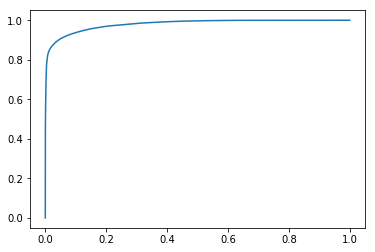

In [55]:
fpr, tpr, _ = roc_curve(y, pred)
plt.plot(fpr, tpr);
print(roc_auc_score(y, pred))